<h2>
    <u>Phase Retrieval from Spectral Interferometry Spectral Data</u>
</h2>

This file performs the delta phi retrieval for given spectral data. You need to provide three files:

1. Reference arm spectrum,
2. Fibre arm spectrum,
3. Spectral intereference (combined).

You may need to adjust the arguments in the DeltaPhiRetrievalProcedure. 
It is assumed you are working in wavelengths, nm, but you can adjust the code as needed.

Load necessary packages**:

In [42]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import Functions as f
sif = f.SI_Functions()
from RefractiveIndexClass import RefractiveIndex as RI

** Note, the Functions class is custom built and needs to be in your working repository. Find them on [Github](https://github.com/jmorse2020/Physics-FYP).

Add your data files here:

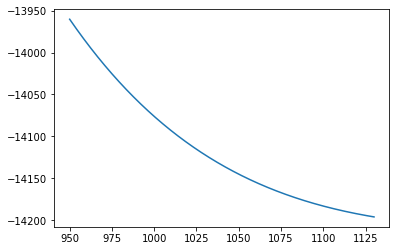

In [43]:
def m2nm(x):
    return x * 1e9

wavelengths = np.linspace(950, 1130, 10000) # [nm]
ZDW = 1280                          # Zero delay wavelngth [nm]
delta = ZDW / 4                     # phase shift
central_wavelength = 1040           # [nm]
sigma = 20                          # Bandwidth
L_f = 0.2                           # Fibre length [m]
L_f = m2nm(L_f)                     # Fibre length [nm]
L_air = - L_f * RI.n_group(RI.n_fs, ZDW) + delta                               # Required air difference for ZDW

# Interfernce
deltaPhi = 2 * np.pi / wavelengths * (L_air  + L_f * RI.n_fs(wavelengths))     # Spectral phase difference
plt.plot(wavelengths, deltaPhi)
wavelengths_sim = wavelengths
spectral_phase_sim = 1 + np.cos(deltaPhi)

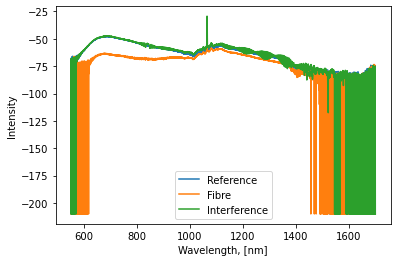

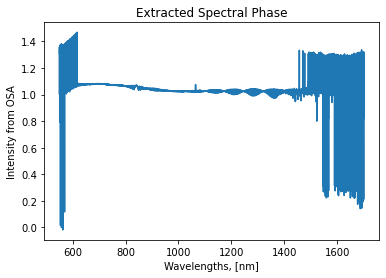

In [44]:
# Add your paths ...
reference_arm_data_file_path = "/Users/jackmorse/Documents/University/Year 4/Semester 1/FYP/Physics-FYP/Data Files/21-Nov-2023-data/no-poi-reference-arm-550-1700nm-1.CSV"
fibre_arm_data_file_path = "/Users/jackmorse/Documents/University/Year 4/Semester 1/FYP/Physics-FYP/Data Files/21-Nov-2023-data/no-poi-fibre-arm-550-1700nm-1.CSV"
spectral_interference_data_file_path = "/Users/jackmorse/Documents/University/Year 4/Semester 1/FYP/Physics-FYP/Data Files/21-Nov-2023-data/no-poi-spectral-interference-550-1700nm-1.CSV"

# Provide information about your data (it is assummed consistent across files):
skip_rows = 40
header = None
is_log = True
wavelength_col_index = 0
intensity_header_name = 0

def LogConversion(y):
    return 10**(y / 10)

# Data will be read
reference_data = pd.read_csv(reference_arm_data_file_path, header = header, skiprows = skip_rows)
wavelengths = reference_data[0]
reference_arm_intensity = reference_data[1]
fibre_data = pd.read_csv(fibre_arm_data_file_path, header = header, skiprows = skip_rows)
fibre_arm_intensity = fibre_data[1]
spectral_interference_data = pd.read_csv(spectral_interference_data_file_path, header = header, skiprows = skip_rows)
spectral_interference_intensity = spectral_interference_data[1]

plt.plot(wavelengths, reference_arm_intensity, label = "Reference")
plt.plot(wavelengths, fibre_arm_intensity, label = "Fibre")
plt.plot(wavelengths, spectral_interference_intensity, label = "Interference")
plt.xlabel("Wavelength, [nm]")
plt.ylabel("Intensity")
plt.legend()
plt.show()

if is_log:
    for data in [reference_arm_intensity, fibre_arm_intensity, spectral_interference_intensity]:
        data = LogConversion(data)

# Convert and extract the phase by dividing by the other arms...
spectral_phase =  ((spectral_interference_intensity - reference_arm_intensity - fibre_arm_intensity) + np.sqrt(reference_arm_intensity * fibre_arm_intensity)) / (2 * np.sqrt(reference_arm_intensity * fibre_arm_intensity))
plt.plot(wavelengths, spectral_phase, label="Extracted spectral phase")
plt.title("Extracted Spectral Phase")
plt.xlabel("Wavelengths, [nm]")
plt.ylabel("Intensity from OSA")
plt.show()


Shift amount:  3611


/Users/jackmorse/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:102: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/Users/jackmorse/Documents/University/Year 4/Semester 1/FYP/Physics-FYP/Functions.py:118: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.subplot(2, 1, 2)
/Users/jackmorse/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:102: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


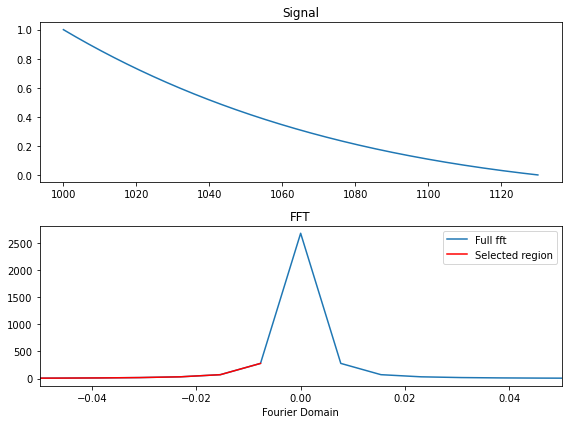

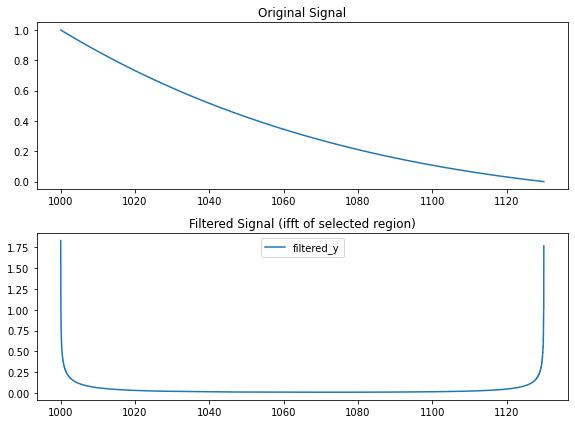

[ 1.3362481   1.26550826  1.26550478 ... -4.52826172 -4.52826502
 -4.57204965]
MIN:  -4.57204964635249
MAX:  1.336248099629656
Final ys:
[ 1.3362481   1.26550826  1.26550478 ... -4.52826172 -4.52826502
 -4.57204965]


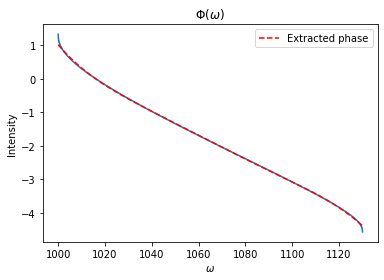

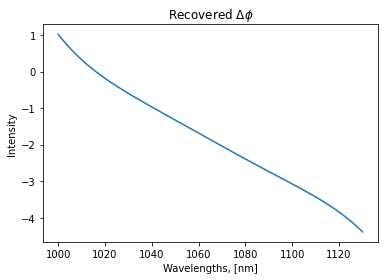

In [45]:
wavelengths = wavelengths_sim
spectral_phase = spectral_phase_sim
# You can filter the spectral phase data, e.g. if it baloons near edges or contains a point of inflection you wish to remove ...
min_spectral_phase_wavelength = 1000
max_spectral_phase_wavelength = 1300
if min_spectral_phase_wavelength != None and max_spectral_phase_wavelength != None:
    indices = np.where((wavelengths >= min_spectral_phase_wavelength) & (wavelengths <= max_spectral_phase_wavelength))[0]
    wavelengths = wavelengths[indices]
    spectral_phase = spectral_phase[indices]  

# You may have to manually adjust parameters. The main ones are keep_min_freq and fft_xlim.
coefficients = sif.DeltaPhiRetrievalProcedure(x=wavelengths, y=spectral_phase, order = 5, keep_min_freq = 0.002, keep_max_freq = -1, side = "left", show_plots = True, fft_x_lim = [-0.05, 0.05], fft_y_lim=None, hanning = False, normalise=True)[1]
phi = lambda var: np.poly1d(coefficients)(var)
plt.plot(wavelengths, phi(wavelengths))
plt.title("Recovered $\Delta \phi$")
plt.xlabel("Wavelengths, [nm]")
plt.ylabel("Intensity") # Think about the units, might be in rad something.
plt.show()

Here's what the extracted refractive index looks like:

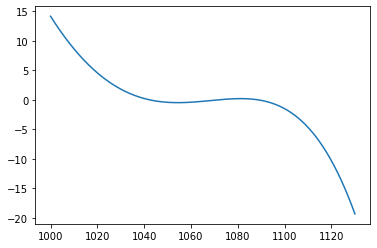

In [46]:
beta = sif.ObtainBetaFromPhi(phi, 0.575)
GVD = sif.GVD(beta)


# n_eff = sif.Obtain_n(beta)

plt.plot(wavelengths, np.array(GVD(wavelengths))*1e28)
